We implement the speeding up at no job left behind in the completely online version of the policy, and see if it matches our heuristic.

In [1]:
%matplotlib inline
from pylab import *
import sys
from collections import namedtuple
import random
import time
import numpy as np

In [2]:
def log_normal(mu=0, sigma=1):
    return e**(mu+sigma*np.random.normal())

def exp_samples(lambd=1,n=1):
    """
    generates a numpy array of n samples distributed according to
    an exponential distribution with parameter λ
    """
    random.seed(time.time())
    return (-1/lambd)*log(rand(n))

def exp(lambd=1):
    """
    generates a sample distributed according to
    an exponential distribution with parameter λ
    """
    if lambd < 0:
        return inf()
    random.seed(time.time())
    return (-1/lambd)*log(rand())

def inf():
    return 999999


def printarray(a): 
    print(np.around(a, 3))
    

In [3]:
def gen_interarrivals_and_services(lambd, mu1, n):
    return exp_samples(lambd, n), exp_samples(mu1, n)

In [4]:
def lambd_range(k, g):
    print("Min range %f" % (1-k))
    print("Max range %f" % (1-k+g*k))

def min_threshold(lambd, mu1, mu2, g):
    rho1 = lambd / mu1
    rho2 = lambd / mu2
    return math.ceil(math.log((g*(1-rho2)*rho1) / ((1-rho1)*rho2 - g*(rho2 - rho1)), rho1))

def min_g(lambd, mu1, mu2):
    rho1 = lambd / mu1
    rho2 = lambd / mu2
    return (rho1*rho2 - rho2) / (rho1 - rho2)

In [48]:
k = 0.1
g = .25
mu1 = 1 - k
mu2 = 1
n = 3000


    
# Indicies for counting surge
start = int(0.1 * n)
end = int(0.9 * n)

In [49]:
print(lambd_range(k, g))
lambd = 0.91

Min range 0.900000
Max range 0.925000
None


In [50]:
threshold = min_threshold(lambd, mu1, 1, g)

In [51]:
interarrivals, services = gen_interarrivals_and_services(lambd, mu1, n)

arrival_times = []
for i in range(len(interarrivals)):
    arrival_times.append(sum(interarrivals[0:i + 1]))
#print(arrival_times)

service_times = [arrival_times[0] + services[0]]
for i in range(1, len(services)):
    service_times.append(max(arrival_times[i], service_times[i - 1]) + services[i])
#print(service_times)

In [52]:
def generate_T_N(interarrivals, services):
    T = [0]
    N = [0]

    arrival_index = 0
    service_index = 0
  
    arrival_times = []
    for i in range(len(interarrivals)):
        arrival_times.append(sum(interarrivals[0:i + 1]))
    #print(arrival_times)

    service_times = [arrival_times[0] + services[0]]
    for i in range(1, len(services)):
        service_times.append(max(arrival_times[i], service_times[i - 1]) + services[i])
    #print(service_times)

    next_arrival = arrival_times[arrival_index]
    next_service = service_times[service_index]

    while min(next_arrival, next_service) != inf():
        if next_arrival < next_service:
            N.append(N[-1] + 1)
            T.append(next_arrival)
            arrival_index += 1
            if arrival_index == len(arrival_times):
                next_arrival = inf()
            else:
                next_arrival = arrival_times[arrival_index]
        else:
            N.append(N[-1] - 1)
            T.append(next_service)
            service_index += 1
            if service_index == len(service_times):
                next_service = inf()
            else:
                next_service = service_times[service_index]

    return T, N

In [53]:
def implement_threshold(interarrvials, services, threshold):
    T = [0]
    N = [0]
    in_surge_num = 0
    in_surge_denom = 0
    S = 0
    start_measuring_surge = 0

    arrival_index = 0
    service_index = 0
  
    arrival_times = []
    for i in range(len(interarrivals)):
        arrival_times.append(sum(interarrivals[0:i + 1]))
    #print(arrival_times)

    service_times = [arrival_times[0] + services[0]]
    for i in range(1, len(services)):
        service_times.append(max(arrival_times[i], service_times[i - 1]) + services[i])
    #print(service_times)

    next_arrival = arrival_times[arrival_index]
    next_service = service_times[service_index]

    while min(next_arrival, next_service) != inf():
        if next_arrival < next_service:
            N.append(N[-1] + 1)
            T.append(next_arrival)
            arrival_index += 1
            if arrival_index == len(arrival_times):
                next_arrival = inf()
            else:
                next_arrival = arrival_times[arrival_index]
        else:
            N.append(N[-1] - 1)
            T.append(next_service)
            service_index += 1
            if T[-1] >= start and T[-1] <= end:
                in_surge_denom += 1
            if service_index == len(service_times):
                next_service = inf()
            else:
                next_service = service_times[service_index]
        if N[-1] >= threshold:
            services[service_index] = (mu1) * services[service_index]
            if T[-1] >= start and T[-1] <= end:
                in_surge_num += 1
            for i in range(service_index, len(services)):
                service_times[i] = max(arrival_times[i], service_times[i - 1]) + services[i]
            next_service = service_times[service_index]

        ###### SURGE count and proportion #####
        #if T[-1] > 200:
        #    if in_surge == 0 and S == 0: # first time, mark t_temp
        #        start_measuring_surge = T[-2]
        #    t_delta = T[-1] - T[-2]
        #    S = S + (t_delta * N[-2])
        #    if N[-2] >= threshold:
        #        in_surge = in_surge + t_delta

    #S = S / (T[-1] - start_measuring_surge)
    #in_surge = in_surge / (T[-1] - start_measuring_surge)
    return T, N, S, in_surge_num / in_surge_denom

In [54]:
def implement_speedup(interarrivals, services, window, p_speedup):
    w = np.zeros(n) # waiting time array
    index = 0
    
    # Counting the proportion of jobs we speed up, can be no more than g
    speed_up_num = 0
    speed_up_denom = 0

    for index in range(n - 1):
        #lookahead_range = 0
        for i in range(index, min(index + window, n - 1)):
            #lookahead_range += min(services[i] - interarrivals[i], services[i])
            w[i + 1] = max(w[i] + services[i] - interarrivals[i], 0)
            if w[i + 1] <= 0:
                #print("Not speeding up job at T=%.2f" % (arrival_times[index]))
                break
            # if we reach the end or it comes back down within a certain window
            if i == min(index + window - 1, n - 2):
                p = rand()
                if p < p_speedup:
                    services[index] = (mu1) * services[index]
                    if index >= start and index <= end:
                        speed_up_num += 1
                    #print("Speeding up job at T=%.2f" % (arrival_times[index]))
        if index >= start and index <= end:
            speed_up_denom += 1

        w[index + 1] = max(w[index] + services[index] - interarrivals[index], 0)
    
    T2, N2 = generate_T_N(interarrivals, services)
    return T2, N2, w[start:end], speed_up_num / speed_up_denom

k = 0.10
g = 0.25


Threshold policy with threshold 37
Threshold speed up for 0.30 proportion of time
Threshold avg queue length 26.56


NJLB policy with infinite lookahead, surge 0.4 of time when lookahead conditions are not met
NJLB speed up for 0.24 proportion of time
NJLB avg queue length 25.89
NJLB Expected waiting time 29.98


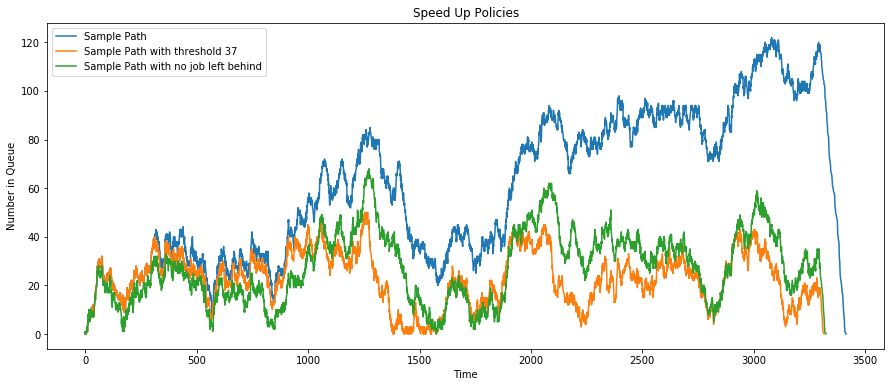

In [55]:
print("k = %.2f" % (k))
print("g = %.2f" % (g))
print("\n")
T, N = generate_T_N(interarrivals.copy(), services.copy())
T_threshold, N_threshold, S, in_surge = implement_threshold(interarrivals.copy(), services.copy(), threshold)
print("Threshold policy with threshold %d" % (threshold))
print("Threshold speed up for %.2f proportion of time" % (in_surge))
print("Threshold avg queue length %.2f" % (np.mean(N_threshold[start:end])))
#print("Threshold average Q %.2f" % (S))
print("\n")
T_njlb, N_njlb, w, in_surge_2 = implement_speedup(interarrivals.copy(), services.copy(), 10000, .4)
print("NJLB policy with infinite lookahead, surge 0.4 of time when lookahead conditions are not met")
print("NJLB speed up for %.2f proportion of time" % (in_surge_2))
print("NJLB avg queue length %.2f" % (np.mean(N_njlb[start:end])))
print("NJLB Expected waiting time %.2f" % (np.mean(w)))


figure(figsize=(15,6))
plot(T, N, label='Sample Path')
plot(T_threshold, N_threshold, label='Sample Path with threshold %d' % (threshold))
plot(T_njlb, N_njlb, label='Sample Path with no job left behind')
xlabel('Time')
ylabel('Number in Queue')
title("Speed Up Policies")
legend()

In [56]:

T_njlb2, N_njlb2, w2, in_surge_22 = implement_speedup(interarrivals.copy(), services.copy(), 10, 1)
print("NJLB speed up for %.2f proportion of time" % (in_surge_22))
print("NJLB Expected waiting time %.2f" % (np.mean(w2)))

NJLB speed up for 0.80 proportion of time
NJLB Expected waiting time 11.69


In [57]:

T_njlb2, N_njlb2, w2, in_surge_22 = implement_speedup(interarrivals.copy(), services.copy(), 100, 1)
print("NJLB speed up for %.2f proportion of time" % (in_surge_22))
print("NJLB Expected waiting time %.2f" % (np.mean(w2)))

NJLB speed up for 0.54 proportion of time
NJLB Expected waiting time 12.95
